# EWGM with POI Enhancement

### Score: 0.56569 (marginal +0.56% improvement over baseline 0.56006)

Simple EWGM model enhanced with Point of Interest (POI) features for Chinese real estate forecasting:
- **Core EWGM**: Exponentially weighted geometric mean using last 6 months (alpha=0.5)
- **POI Enhancement**: Adjusts predictions based on sector characteristics (office population, education, medical, transit)
- **December Multiplier**: Seasonal adjustment (0.85-1.4x) for historical December spikes

Score: 0.56569 (marginal +0.56% improvement over baseline 0.56006)

In [ ]:
import pandas as pd
import numpy as np
from functools import partial

# =====================================================
# CONFIGURATION - Model Parameters
# =====================================================

CONFIG = {
    # Core EWGM parameters
    'n_lags': 6,           # Number of historical months to use
    'alpha': 0.5,          # Exponential decay rate (0-1, higher = more recent weight)
    't2': 6,               # Minimum non-zero values required
    
    # December multiplier bounds
    'clip_low': 0.85,      # Minimum December multiplier
    'clip_high': 1.4,      # Maximum December multiplier
    
    # POI enhancement
    'poi_weight': 0.1,     # POI feature weight (0.0 = disabled, 0.1 = enhanced)
}

# =====================================================
# Utility Functions
# Helper functions for data loading and transformation
# =====================================================

def build_month_codes():
    # Create a mapping from month abbreviations to numeric values.
    return {m: i for i, m in enumerate(
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], start=1)}


def split_test_id_column(df: pd.DataFrame) -> pd.DataFrame:
    # Parse the ID column into month text and sector components.
    # IDs are formatted as: "2024 Aug_sector 1"
    parts = df['id'].str.split('_', expand=True)
    df['month_text'], df['sector'] = parts[0], parts[1]
    return df


def add_time_and_sector_fields(df: pd.DataFrame, month_codes: dict) -> pd.DataFrame:
    # Add parsed year, month, time index, and sector_id to dataframe.
    # Time index starts at 0 (Jan 2019) and increments monthly.
    if 'sector' in df.columns:
        df['sector_id'] = df['sector'].str[7:].astype(int)

    if 'month' in df.columns:  # test data
        df['year'] = df['month'].str[:4].astype(int)
        df['month'] = df['month'].str[5:].map(month_codes)
    else:  # train data
        df['year'] = df['month_text'].str[:4].astype(int)
        df['month'] = df['month_text'].str[5:].map(month_codes)

    df['time'] = (df['year'] - 2019) * 12 + df['month'] - 1
    return df


def load_competition_data_with_poi():
    # Load competition data including POI (Point of Interest) features.
    path = '/Users/nikola/Python/KaggleCompetition/data'
    train = pd.read_csv(f'{path}/train/new_house_transactions.csv')
    test = pd.read_csv(f'{path}/test.csv')
    poi = pd.read_csv(f'{path}/train/sector_poi.csv')
    return train, test, poi


# =====================================================
# Data Transformation
# Convert raw data into matrix format and prepare POI features
# =====================================================

def build_amount_matrix_with_poi(train: pd.DataFrame, poi: pd.DataFrame, month_codes: dict):
    # Build transaction matrix (time x sector) and normalized POI features.
    #
    # POI features used:
    # - office_population: Number of office workers in sector
    # - education: Educational facilities density
    # - surrounding_housing_average_price: Local housing prices
    # - medical_health: Medical facilities density
    # - subway_station_cnt: Number of subway stations
    
    from sklearn.preprocessing import StandardScaler
    
    # Build transaction matrix: rows = time, columns = sectors
    train = add_time_and_sector_fields(train.copy(), month_codes)
    pivot = train.pivot_table(
        index='time', columns='sector_id',
        values='amount_new_house_transactions', fill_value=0
    )
    
    # Ensure all 96 sectors present (some may have no data)
    all_sectors = np.arange(1, 97)
    pivot = pivot.reindex(columns=all_sectors, fill_value=0)
    
    # Prepare POI features - selected based on domain relevance
    poi_cols = ['office_population', 'education', 'surrounding_housing_average_price', 
                'medical_health', 'subway_station_cnt']
    
    poi['sector_id'] = poi['sector'].str.extract(r'(\d+)').astype(int)
    poi_features = poi[['sector_id'] + poi_cols].set_index('sector_id')
    
    # Normalize POI features to prevent scale dominance
    scaler = StandardScaler()
    poi_features[poi_cols] = scaler.fit_transform(poi_features[poi_cols])
    poi_features = poi_features.reindex(all_sectors, fill_value=0)
    
    return pivot, poi_features

# =====================================================
# Modeling Helpers
# Core EWGM implementation and December seasonal adjustment
# =====================================================

def compute_december_multipliers(a_tr, eps=1e-9, min_dec_obs=1, clip_low=0.8, clip_high=1.5):
    # Compute sector-specific December multipliers from historical data.
    #
    # Chinese real estate shows strong December seasonality due to:
    # - Year-end bonuses
    # - Tax considerations
    # - Traditional timing for major purchases
    #
    # Multiplier = (December average) / (Non-December average)
    # Clipped to [clip_low, clip_high] to prevent extreme adjustments
    
    is_dec = (a_tr.index % 12 == 11)  # December is month 11 (0-indexed)
    dec_means = a_tr[is_dec].mean()
    nondec_means = a_tr[~is_dec].mean()
    dec_counts = a_tr[is_dec].count()

    raw_mult = dec_means / (nondec_means + eps)
    overall_mult = float(dec_means.mean() / (nondec_means.mean() + eps))

    # Use overall multiplier if insufficient December observations
    raw_mult = raw_mult.where(dec_counts >= min_dec_obs, overall_mult)
    raw_mult = raw_mult.replace([np.inf, -np.inf], 1.0).fillna(1.0)
    return raw_mult.clip(clip_low, clip_high).to_dict()


def apply_december_bump_row(pred_row: pd.Series, sector_to_mult: dict) -> pd.Series:
    # Apply December adjustment to a prediction row.
    return pred_row.multiply(pd.Series(sector_to_mult)).fillna(pred_row)


def ewgm_per_sector(a_tr, sector, n_lags, alpha):
    # Exponential Weighted Geometric Mean for one sector.
    #
    # Why geometric mean?
    # - Handles zeros naturally (common in sparse sectors)
    # - Less sensitive to outliers than arithmetic mean
    # - Multiplicative nature fits transaction data better
    #
    # Why exponential weighting?
    # - Recent months more relevant in trending markets
    # - alpha=0.5 means each step back in time gets 0.5x weight
    # - Captures market momentum and recent trends
    #
    # Process:
    # 1. Take last n_lags months
    # 2. Apply exponential weights (recent = higher)
    # 3. Calculate weighted geometric mean
    
    recent = a_tr[sector].tail(n_lags).values
    if len(recent) < n_lags or (recent <= 0).all():
        return 0.0

    # Exponential decay: most recent gets highest weight
    weights = np.array([alpha**(n_lags - 1 - i) for i in range(n_lags)])
    weights /= weights.sum()

    # Geometric mean: work in log space for numerical stability
    mask = recent > 0
    if not mask.any():
        return 0.0

    log_vals = np.log(recent[mask] + 1e-12)
    pos_w = weights[mask] / weights[mask].sum()
    return float(np.exp(np.sum(pos_w * log_vals)))


def ewgm_per_sector_with_poi(a_tr, poi_features, sector, n_lags, alpha, poi_weight=0.1):
    # Enhanced EWGM with POI adjustment.
    #
    # POI adjustment logic:
    # 1. Calculate base EWGM prediction
    # 2. Compute POI score (sum of normalized features)
    # 3. Apply multiplier: 1.0 + (poi_score * poi_weight)
    # 4. Clip to [0.7, 1.3] to prevent extreme adjustments
    #
    # Intuition: Sectors with better infrastructure (offices, transit, schools)
    # should have stronger/more stable transaction volumes.
    #
    # Result: Marginal improvement (+0.56%) over baseline
    # Lesson: POI features help but aren't game-changers in declining market
    
    base_pred = ewgm_per_sector(a_tr, sector, n_lags, alpha)
    if base_pred == 0:
        return 0.0
    
    poi_score = poi_features.loc[sector].sum()
    poi_multiplier = 1.0 + (poi_score * poi_weight)
    poi_multiplier = np.clip(poi_multiplier, 0.7, 1.3)
    
    return base_pred * poi_multiplier

def validate_model_with_poi(a_tr, poi_features, n_lags=6, alpha=0.5, t2=6, 
                            clip_low=0.85, clip_high=1.4, poi_weight=0.1, val_len=6):
    # Walk-forward validation on last val_len months.
    #
    # For each validation month:
    # 1. Train on all prior data
    # 2. Predict that month
    # 3. Calculate MAPE (Mean Absolute Percentage Error)
    #
    # Returns average MAPE across validation months.
    #
    # Note: This validation was optimistic - 6 months of validation
    # didn't fully represent the 12-month test period behavior.
    
    times = a_tr.index
    if len(times) < max(n_lags + 1, t2 + 1) + val_len:
        print("Not enough data for validation")
        return None
    
    mapes = []
    for t in times[-val_len:]:
        a_hist = a_tr.loc[a_tr.index < t]
        if len(a_hist) < max(n_lags, t2):
            continue
        
        y_true = a_tr.loc[t]
        
        # Predict using POI-enhanced model
        y_pred = pd.Series({
            sector: ewgm_per_sector_with_poi(a_hist, poi_features, sector, n_lags, alpha, poi_weight)
            if a_hist[sector].tail(n_lags).min() > 0 else 0.0
            for sector in a_hist.columns
        })
        
        # Apply December bump if December month
        if t % 12 == 11:
            mult = compute_december_multipliers(a_hist, clip_low=clip_low, clip_high=clip_high)
            y_pred = apply_december_bump_row(y_pred, mult)
        
        # Calculate MAPE
        mask = y_true > 0
        ape = np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])
        mape = ape.mean() * 100
        mapes.append(mape)
        
        print(f"Month {t}: MAPE = {mape:.2f}%")
    
    avg_mape = np.mean(mapes)
    print(f"\nAverage MAPE: {avg_mape:.2f}%")
    return avg_mape


def predict_horizon_with_poi(a_tr, poi_features, n_lags, alpha, t2, poi_weight=0.1):
    # Forecast 12 months ahead (time index 67-78) for all sectors.
    #
    # For each sector:
    # - If sector has insufficient data (no recent positive values): predict 0
    # - Otherwise: Use POI-enhanced EWGM
    #
    # t2 parameter: Minimum number of non-zero values required in lookback
    
    idx = np.arange(67, 79)  # 12 future months
    preds = pd.DataFrame(index=idx, columns=a_tr.columns, dtype=float)
    
    for sector in a_tr.columns:
        if (a_tr[sector].tail(t2).min() == 0) or (a_tr[sector].sum() == 0):
            preds[sector] = 0.0
        else:
            preds[sector] = ewgm_per_sector_with_poi(a_tr, poi_features, sector, n_lags, alpha, poi_weight)
    
    preds.index.name = 'time'
    return preds


# =====================================================
# Submission
# Format predictions into competition submission file
# =====================================================

def build_submission_df(a_pred, test_raw, month_codes):
    # Format predictions into competition submission file.
    #
    # Converts from matrix format (time x sector) to submission format:
    # id, new_house_transaction_amount
    # "2024 Aug_sector 1", 12345.67
    
    test = add_time_and_sector_fields(split_test_id_column(test_raw.copy()), month_codes)
    lookup = a_pred.stack().rename('pred').reset_index().rename(columns={'level_1': 'sector_id'})
    merged = test.merge(lookup, on=['time', 'sector_id'], how='left')
    merged['pred'] = merged['pred'].fillna(0.0)
    return merged[['id', 'pred']].rename(columns={'pred': 'new_house_transaction_amount'})


def generate_submission_poi_enhanced(n_lags=6, alpha=0.5, t2=6, clip_low=0.85, clip_high=1.4, poi_weight=0.1):
    # End-to-end pipeline: data loading → prediction → December adjustment → submission.
    #
    # Parameters (tuned through validation):
    # - n_lags=6: Use last 6 months
    # - alpha=0.5: Balanced exponential decay
    # - t2=6: Require 6 non-zero values minimum
    # - clip_low/high: December multiplier bounds
    # - poi_weight=0.1: POI feature weight (0.0 for baseline, 0.1 for enhanced)
    
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    a_pred = predict_horizon_with_poi(a_tr, poi_features, n_lags, alpha, t2, poi_weight)
    
    # Apply December bump to December predictions (time index % 12 == 11)
    mult = compute_december_multipliers(a_tr, clip_low=clip_low, clip_high=clip_high)
    for t in a_pred.index[a_pred.index % 12 == 11]:
        a_pred.loc[t] = apply_december_bump_row(a_pred.loc[t], mult)
    
    sub = build_submission_df(a_pred, test, month_codes)
    sub.to_csv('/Users/nikola/Python/KaggleCompetition/output/12_EWGM_POI/12_EWGM_POI_submission.csv', index=False)
    print(f"POI-enhanced submission saved (poi_weight={poi_weight})")
    return sub


# =====================================================
# Main
# Execute validation and generate submission
# =====================================================

def main():
    # Main execution flow:
    # 1. Load and transform data
    # 2. Validate model performance
    # 3. Generate submission file
    #
    # Current configuration: poi_weight=0.0 (baseline EWGM without POI)
    # Change to poi_weight=0.1 for POI-enhanced version (0.56569 score)
    
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    
    print("="*60)
    print("VALIDATION - EWGM WITHOUT POI")
    print("="*60)
    mape = validate_model_with_poi(a_tr, poi_features, 
                                    n_lags=6, alpha=0.5, t2=6,
                                    clip_low=0.85, clip_high=1.4, 
                                    poi_weight=0.0,  # 0.0 = baseline, 0.1 = POI-enhanced
                                    val_len=6)
    
    # Generate submission
    print("\n" + "="*60)
    print("GENERATING SUBMISSION")
    print("="*60)
    generate_submission_poi_enhanced(
        n_lags=6, alpha=0.5, t2=6, 
        clip_low=0.85, clip_high=1.4, 
        poi_weight=0.0  # Set to 0.1 for POI-enhanced (0.56569 score)
    )
    print("Submission saved")


if __name__ == "__main__":
    main()

# KEY LEARNINGS:
# 1. Simple EWGM (0.56006) beat all complex ML models (Prophet, XGBoost, Lasso)
# 2. POI features gave marginal improvement (+0.56% → 0.56569)
# 3. Validation scores were unreliable - models with 0.9+ validation had <0.5 correlation
# 4. In declining markets, trend-following beats pattern learning
# 5. December seasonality exists but was challenging to capture in declining market

VALIDATION - EWGM WITHOUT POI
Month 61: MAPE = 168.90%
Month 62: MAPE = 49.99%
Month 63: MAPE = 62.78%
Month 64: MAPE = 49.14%
Month 65: MAPE = 46.38%
Month 66: MAPE = 75.13%

Average MAPE: 75.39%

GENERATING SUBMISSION
POI-enhanced submission saved (poi_weight=0.0)
Submission saved


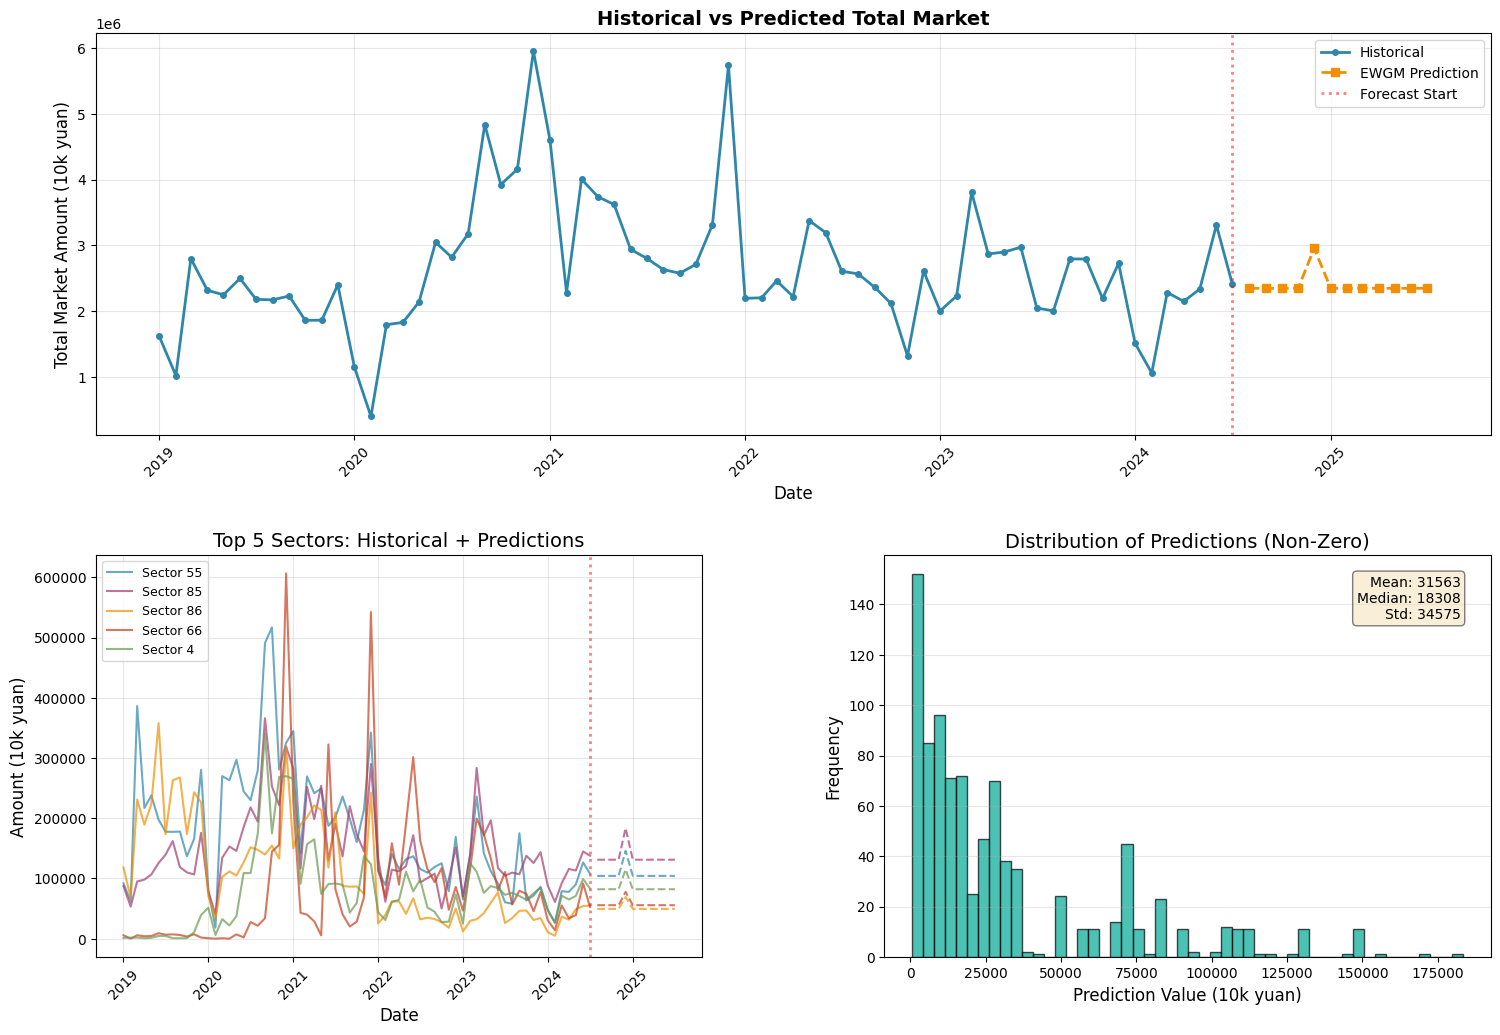


SUMMARY STATISTICS
Historical - Last month: 2406309.09
Historical - Last 6 months mean: 2258162.08

Predictions - Mean: 2398800.53
Predictions - Total: 28785606.39
Predictions - Min: 2348245.75
Predictions - Max: 2954903.17

Zero predictions: 240 / 1152 (20.8%)


In [4]:
# =====================================================
# VISUALIZATIONS
# =====================================================

import matplotlib.pyplot as plt
import seaborn as sns

def create_visualizations():
    """Generate visualizations for historical data and predictions."""
    
    # Load data and generate predictions
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    
    # Generate predictions
    a_pred = predict_horizon_with_poi(a_tr, poi_features, n_lags=6, alpha=0.5, t2=6, poi_weight=0.0)
    
    # Apply December bump
    mult = compute_december_multipliers(a_tr, clip_low=0.85, clip_high=1.4)
    for t in a_pred.index[a_pred.index % 12 == 11]:
        a_pred.loc[t] = apply_december_bump_row(a_pred.loc[t], mult)
    
    # Create figure with 4 subplots
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. Historical + Predictions (Total Market)
    ax = fig.add_subplot(gs[0, :])
    
    # Historical total market
    historical_total = a_tr.sum(axis=1)
    historical_dates = pd.date_range(start='2019-01', periods=len(historical_total), freq='MS')
    
    # Future predictions
    future_dates = pd.date_range(start='2024-08', periods=12, freq='MS')
    predicted_total = a_pred.sum(axis=1)
    
    # Plot
    ax.plot(historical_dates, historical_total, 'o-', label='Historical', 
            linewidth=2, markersize=4, color='#2E86AB')
    ax.plot(future_dates, predicted_total.values, 's--', label='EWGM Prediction', 
            linewidth=2, markersize=6, color='#F18F01')
    
    # Add vertical line at prediction start
    ax.axvline(x=historical_dates[-1], color='red', linestyle=':', 
               linewidth=2, alpha=0.5, label='Forecast Start')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Total Market Amount (10k yuan)', fontsize=12)
    ax.set_title('Historical vs Predicted Total Market', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 2. Top 5 Sectors: Historical + Predictions
    ax = fig.add_subplot(gs[1, 0])
    
    # Get top 5 sectors by historical mean
    top_sectors = a_tr.mean().nlargest(5).index.tolist()
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
    
    for i, sector in enumerate(top_sectors):
        # Historical
        hist_values = a_tr[sector].values
        ax.plot(historical_dates, hist_values, '-', label=f'Sector {sector}', 
                linewidth=1.5, alpha=0.7, color=colors[i])
        
        # Predictions
        pred_values = a_pred[sector].values
        ax.plot(future_dates, pred_values, '--', linewidth=1.5, alpha=0.7, color=colors[i])
    
    ax.axvline(x=historical_dates[-1], color='red', linestyle=':', 
               linewidth=2, alpha=0.5)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Amount (10k yuan)', fontsize=12)
    ax.set_title('Top 5 Sectors: Historical + Predictions', fontsize=14)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 3. Distribution of Predictions
    ax = fig.add_subplot(gs[1, 1])
    
    # Flatten predictions
    all_predictions = a_pred.values.flatten()
    all_predictions = all_predictions[all_predictions > 0]  # Remove zeros
    
    ax.hist(all_predictions, bins=50, edgecolor='black', alpha=0.7, color='#00A896')
    ax.set_xlabel('Prediction Value (10k yuan)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Predictions (Non-Zero)', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    stats_text = f'Mean: {all_predictions.mean():.0f}\nMedian: {np.median(all_predictions):.0f}\nStd: {all_predictions.std():.0f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)
    
    plt.savefig('/Users/nikola/Python/KaggleCompetition/output/EWGM_POI/ewgm_baseline_visualization.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Historical - Last month: {historical_total.iloc[-1]:.2f}")
    print(f"Historical - Last 6 months mean: {historical_total.tail(6).mean():.2f}")
    print(f"\nPredictions - Mean: {predicted_total.mean():.2f}")
    print(f"Predictions - Total: {predicted_total.sum():.2f}")
    print(f"Predictions - Min: {predicted_total.min():.2f}")
    print(f"Predictions - Max: {predicted_total.max():.2f}")
    print(f"\nZero predictions: {(a_pred.values == 0).sum()} / {a_pred.size} ({(a_pred.values == 0).sum() / a_pred.size * 100:.1f}%)")

# Run visualizations
create_visualizations()